看这篇文章之前需要先了解决策树，梯度提升（gradient boosting）<br />
这篇文章会用最简单的例子详细说明xgboost里的树是如何生长的。废话不多说，开始吧。<br />
选择波士顿房价数据集进行说明，为了简化说明，只选取其中两个特征（RM、AGE）<br />

In [20]:
import sklearn.datasets
import pandas as pd
import numpy as np
import xgboost as xgb

boston_raw = sklearn.datasets.load_boston()
boston = pd.DataFrame(boston_raw['data'], columns=boston_raw['feature_names'])
boston = boston[['RM', 'AGE']]
labels = boston_raw['target']
boston_all = pd.concat([boston, pd.DataFrame(labels, columns=['label'])], axis=1)

In [3]:
%matplotlib inline

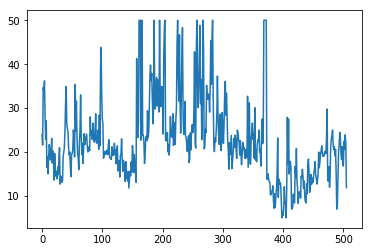

In [5]:
boston_all.label.plot()

xgboost首先会选取0.5作为基本分数，简单的说就是不管特征是什么，我们都预测房价的值为0.5。为什么是0.5。这个是xgboost默认的，你也可以使用其他数值，通过修改xgboost的base_score，只要生成的树足够多，效果是一样的。

根据boosting的原理，我们在残差上（label-0.5）训练构建我们的第一颗树。

要构建一颗树，主要解决两个问题

##### 1.如何找到一个好的树结构
##### 2.叶子节点如何赋值

我们先解决第二个问题，假如我们已经知道树结构，叶子节点如何赋值？ 比如我们现在知道第一颗树是按下面这样构建的, 在特征rm=6.94处进行分裂，树的深度为1，那叶子节点我们如何赋值？

![image.png](attachment:image.png)

根据作者推导的公式我们可以计算

![image.png](attachment:image.png)

如果你选用平方误差，不引入正则项，那计算会比较简单。
既然我们知道了数据集会在rm=6.94处分裂成两组，那自然取每组数据的平均值作为叶子节点的值。

In [6]:
(boston_all[boston_all['RM'] < 6.94].label - 0.5).mean()

19.433720930232557

In [7]:
(boston_all[boston_all['RM'] >= 6.94].label - 0.5).mean()

36.738157894736844

现在我们解决第二个问题，如何找到一个好的树结构。这又可以分为两个问题
##### 1.如何找到分裂点？
##### 2.何时停止生长

xgboost里面寻找分裂点有两种方法，一种是exact greedy algorithm, 一种是Approximate Algorithm。这里我们只讲exact greedy algorithm。具体就是先对特征排序，然后遍历所有的特征寻找分裂点。对于每个分裂，我们如何计算目标函数的变化(gain)，然后取获得最大gain的点作为分裂点。计算方法如下（看起来好像很复杂，但我们使用平方误差，实际计算并不复杂）：

![image.png](attachment:image.png)

我们从树的深度为0开始，每次找到最佳分裂点进行分裂，根据这种方法将树生成到最大深度。这就是贪心算法，即只考虑当前的最佳收益。构建完最大深度后，我们从叶子节点往上剪枝。如果一个节点我们计算的gain是负数，我们就对其进行剪枝。

现在构建树的两个问题已经解决，现在我们来开始构建。

In [9]:
class BestSplitNode:
    """用于记录最佳分裂点"""
    max_gain = -float("inf")
    split_val = None
    best_split_fe = None
    best_split_left = None
    best_split_right = None
    best_left_gain = None
    best_right_gain = None
    best_root_gain = None
    left_val = None
    right_val = None

    def __str__(self):
        return "split feature: {}\n"\
               "split value: {}\n" \
               "Gain: {}\n" \
               "left cover: {}\n" \
               "right cover: {}\n" \
               "left value: {}\n" \
               "right value: {}\n".format(self.best_split_fe, 
                                          self.split_val, 
                                          self.max_gain, 
                                          len(self.best_split_left), 
                                          len(self.best_split_right),
                                          self.left_val,
                                          self.right_val)


def calculate_gain(df, pre_val, reg_lambda):
    """
    :param df: 数据集（dataframe)
    :param pre_val: 前面树的预测之和
    :param reg_lambda: 正则参数
    :return: 
    """
    return np.sum(df.label - pre_val) ** 2 / (len(df) + reg_lambda)


def calculate_leave_val(df, pre_val, reg_lambda):
    return np.sum(df.label - pre_val) / (len(df) + reg_lambda)

    
def find_split(root_df, pre_val=0.5, reg_lambda=0, gamma=0):
    best_split_node = BestSplitNode()
    root_gain = calculate_gain(root_df, pre_val, reg_lambda)
    for feature in ['RM', 'AGE']:
        for val in root_df[feature]:
            left = root_df[root_df[feature] < val]
            right = root_df[root_df[feature] >= val]
            if left.empty or right.empty:
                continue
            left_gain = calculate_gain(left, pre_val, reg_lambda)
            right_gain = calculate_gain(right, pre_val, reg_lambda)
            gain = left_gain + right_gain - root_gain - gamma
            if gain > best_split_node.max_gain:
                best_split_node.max_gain = gain
                best_split_node.split_val = val
                best_split_node.best_split_left = left
                best_split_node.best_split_right = right
                best_split_node.best_split_fe = feature
                best_split_node.best_left_gain = left_gain
                best_split_node.best_right_gain = right_gain
                best_split_node.best_root_gain = root_gain
                
                # 计算叶子节点值
                best_split_node.left_val = calculate_leave_val(left, pre_val, reg_lambda)
                best_split_node.right_val = calculate_leave_val(right, pre_val, reg_lambda)
                
    return best_split_node

我们先设置树的深度为1，正则项λ=0

In [12]:
root_node = find_split(boston_all)
print(root_node)

split feature: RM
split value: 6.943
Gain: 19339.555026402784
left cover: 430
right cover: 76
left value: 19.433720930232557
right value: 36.738157894736844



计算得对不对呢？我们用xgboost来验证下

In [13]:
from xgboost import XGBRegressor
clf = XGBRegressor(max_depth=1, n_estimators=1, reg_lambda=0, learning_rate=1)
clf.fit(boston, labels)

bst = clf.get_booster()
bst.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,RM,6.941,0-1,0-2,0-1,19339.546900,506.0
1,0,1,0-1,Leaf,NaN,NaN,NaN,NaN,19.433722,430.0
2,0,2,0-2,Leaf,NaN,NaN,NaN,NaN,36.738159,76.0


和我们上面计算的基本一样

## 正则化参数λ

从上面的式子可以看出，λ不仅会影响叶子节点的值，还会影响后续的剪枝。如果λ设置得比较大，有些节点的最佳分裂的gain会是负值，这些在剪枝时会被剪掉。

比如，我们设置树最大深度为2，λ=3

第一个分类点：

In [14]:
root_node = find_split(boston_all, reg_lambda=3)
print(root_node)

split feature: RM
split value: 6.842
Gain: 15941.159142495599
left cover: 419
right cover: 87
left value: 19.084597156398107
right value: 34.387777777777785



在左节点继续分裂：

In [15]:
left_node = find_split(root_node.best_split_left, reg_lambda=3)
print(left_node)

split feature: AGE
split value: 76.5
Gain: 2253.6098906732514
left cover: 190
right cover: 229
left value: 22.022797927461138
right value: 16.39353448275862



在右节点继续分裂：

In [17]:
right_node = find_split(root_node.best_split_right, reg_lambda=3)
print(right_node)

split feature: RM
split value: 8.78
Gain: -172.89232084895775
left cover: 86
right cover: 1
left value: 34.533707865168545
right value: 5.35



这里最佳分裂点gain是负数，我们从最下面往上剪枝，这个节点就去掉（也就是不分裂）

用xgboost验证下

In [18]:
clf = XGBRegressor(max_depth=2, n_estimators=1, reg_lambda=3, learning_rate=1)
clf.fit(boston, labels)

bst = clf.get_booster()
bst.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,RM,6.8375,0-1,0-2,0-1,15941.171900,506.0
1,0,1,0-1,AGE,75.7500,0-3,0-4,0-3,2253.609380,419.0
2,0,2,0-2,Leaf,NaN,NaN,NaN,NaN,34.387779,87.0
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,22.022799,190.0
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,16.393534,229.0


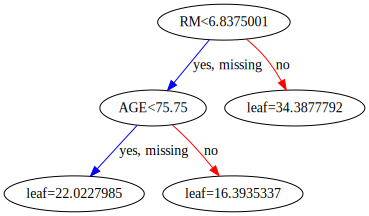

In [21]:
xgb.to_graphviz(bst, num_trees=0)

## 正则化参数γ（gamma)

从gain的计算可以知道，如果γ取值比较大，原本是正的gain会变成负数，从而达到剪枝。

比如上面这个例子，我们在AGE=75.75处分裂的gain是2253.60，如果我们的γ设置得比这个大（比如2500)，那这里的gain变为负值，会被剪枝

In [23]:
root_node = find_split(boston_all, reg_lambda=3, gamma=2500)
left_node = find_split(root_node.best_split_left, reg_lambda=3, gamma=2500)
print(left_node)

split feature: AGE
split value: 76.5
Gain: -246.39010932674864
left cover: 190
right cover: 229
left value: 22.022797927461138
right value: 16.39353448275862



可以看到gain变成负值

用xgboost验证下：

In [24]:
clf = XGBRegressor(max_depth=2, n_estimators=1, reg_lambda=3, learning_rate=1, gamma=2500)
clf.fit(boston, labels)

bst = clf.get_booster()
bst.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,RM,6.8375,0-1,0-2,0-1,15941.171900,506.0
1,0,1,0-1,Leaf,NaN,NaN,NaN,NaN,19.084597,419.0
2,0,2,0-2,Leaf,NaN,NaN,NaN,NaN,34.387779,87.0


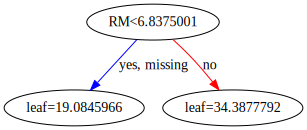

In [25]:
xgb.to_graphviz(bst, num_trees=0)

到这里大家应该知道一颗树是怎么生长的，后续树的生成就是在当前的基础上，对残差进行构建新的树。